# 12 Word World

In this notebook we prepare a minimal setup to have a trainable GPT and some text pattern to be learnt.

## Introduction

In order to make both the vocabulary and the model as tiny as possible, we will:

* use an intentionally limited vocabulary (of only 12, or even 8 words)
* use the simple tokenizer rather than OpenAI's tokenizer (as using it implies a vocabulary size of more than 50k words)
* use a super reduced configuration, much tinier than the small GPT2

In [1]:
# Python dependencies
import warnings
import random

# 3rd Party dependencies
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MaxNLocator
import ipywidgets as widgets

In [2]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

## Defining an Intentionally Limited Vocabulary

We'll train a model with a text that's limited to the following vocabulary.

In [3]:
adjectives = ["serene", "vibrant", "silent", "endless"]
nouns = ["river", "dream", "mountain", "idea"]
verbs = ["flows", "grows", "whispers", "shines"]

We generate random sentences with those words by randomly concatenating a noun, an adjective and a verb.

In [4]:
sentence_count = 100

twelve_word_world = [
    random.choice(adjectives) + " " + random.choice(nouns) + " " + random.choice(verbs)
    for _ in range(sentence_count)
]

### Previewing the Training Text

In [5]:
from scratch.tokenizers.preprocessor import Preprocessor
from scratch.tokenizers.simple_tokenizer import SimpleTokenizer

def strings_to_text(strings: list[str]):
    return " <|endoftext|> ".join(strings) + " <|endoftext|>"

text_data = strings_to_text(twelve_word_world)

text_data

'serene mountain grows <|endoftext|> endless mountain flows <|endoftext|> vibrant river shines <|endoftext|> serene mountain grows <|endoftext|> silent mountain grows <|endoftext|> endless idea shines <|endoftext|> serene mountain whispers <|endoftext|> serene mountain grows <|endoftext|> vibrant mountain flows <|endoftext|> vibrant idea grows <|endoftext|> silent mountain grows <|endoftext|> vibrant idea whispers <|endoftext|> serene idea whispers <|endoftext|> endless idea shines <|endoftext|> endless mountain whispers <|endoftext|> vibrant dream shines <|endoftext|> silent idea grows <|endoftext|> silent mountain flows <|endoftext|> silent mountain flows <|endoftext|> vibrant river shines <|endoftext|> vibrant river whispers <|endoftext|> endless idea shines <|endoftext|> endless idea flows <|endoftext|> silent mountain whispers <|endoftext|> vibrant mountain grows <|endoftext|> vibrant idea flows <|endoftext|> serene dream shines <|endoftext|> serene river whispers <|endoftext|> vi

### Preparing the Tokenizer and Checking the Vocabulary

In [6]:
preprocessor = Preprocessor()
source = preprocessor.preprocess(text_data)
tokenizer = SimpleTokenizer(source)
vocab_size = len(tokenizer.str_to_int)

print("Sentences", len(twelve_word_world))
print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))
print("Vocabulary size", vocab_size)

tokenizer.int_to_str

Sentences 100
Total characters 3515
Total tokens 400
Vocabulary size 14


{0: '<|endoftext|>',
 1: '<|unk|>',
 2: 'dream',
 3: 'endless',
 4: 'flows',
 5: 'grows',
 6: 'idea',
 7: 'mountain',
 8: 'river',
 9: 'serene',
 10: 'shines',
 11: 'silent',
 12: 'vibrant',
 13: 'whispers'}

As the sentences have different length depening on whether we enabled, or not, the use of verbs, we need to calculate the context length.

### Limiting the Context Length

In [7]:
context_length = len(tokenizer.text_to_tokens(twelve_word_world[0] + " <|endoftext|>").squeeze())

context_length

4

## Creating a Tiny GPT Model

We instantiate a very tiny model in order to make it quite easy to debug.

In [8]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig(
    vocab_size = vocab_size,
    context_length = context_length,
    embedding_dimension = 3,
    head_count = 1,
    layer_count = 1,
    forward_layer_size = 1,
    drop_rate = 0,
    qkv_bias = False
)

model = GptModel(config)

model.eval()

GptModel(
  (token_embeddings): Embedding(14, 3)
  (positional_embeddings): Embedding(4, 3)
  (dropout_embeddings): Dropout(p=0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (normalizer): SoftmaxNormalizer()
        (W_query): Linear(in_features=3, out_features=3, bias=False)
        (W_key): Linear(in_features=3, out_features=3, bias=False)
        (W_value): Linear(in_features=3, out_features=3, bias=False)
        (out_proj): Linear(in_features=3, out_features=3, bias=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Gelu()
          (2): Linear(in_features=3, out_features=3, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0, inplace=False)
    )
  )
  (final_normaliz

In [9]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

177

### Storing some Initial Layer States

Now that our model has just been created with random weights, we'll store some of the weights so that we can later compare the initial values with the trained ones.

In [10]:
initial_embeddings = model.token_embeddings.weight.clone().to("cpu")
initial_out_head = model.out_head.weight.clone().to("cpu")

## Preparing the Training and Validation Datasets

In [11]:
train_ratio = 0.9
split_idx = int(train_ratio * len(twelve_word_world))

train_data = strings_to_text(twelve_word_world[:split_idx])
validation_data = strings_to_text(twelve_word_world[split_idx:])

print(validation_data)

silent river whispers <|endoftext|> vibrant mountain flows <|endoftext|> endless dream flows <|endoftext|> serene idea grows <|endoftext|> silent mountain whispers <|endoftext|> endless dream shines <|endoftext|> vibrant mountain grows <|endoftext|> serene dream whispers <|endoftext|> endless mountain whispers <|endoftext|> vibrant mountain grows <|endoftext|>


In [12]:
from scratch.dataloader import create_dataloader

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0,
    tokenizer=tokenizer,
)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0,
    tokenizer=tokenizer,
)

### Checking the Losses before Training

In [13]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 2.83802913535725
Validation loss 2.7850269317626952


## Training the Model

### Preparing a Trainer

In [14]:
from scratch.generators.probabilistic_text_generator import ProbabilisticTextGenerator
from scratch.training.simple_trainer import SimpleTrainer

generator = ProbabilisticTextGenerator(
    model,
    config.context_length,
    temperature = 1.1,
    top_k = 4,
    eos_id = tokenizer.encode("<|endoftext|>")[0]
)

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    tokenizer = tokenizer,
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr = 0.05,
        weight_decay = 0.1
    ),
    generator = generator
)

### Runing the Training Loop

In [15]:
num_epochs = 10

model.disable_debugging()

train_losses, validation_losses, tokens_seen = trainer.train(
    num_epochs = num_epochs,
    eval_freq = 50,
    eval_iter = 10**10,
    start_context = "silent")


- Step 0
- Train loss 2.722821213982322
- Evaluation loss 2.702664613723755
- Generated: silent idea shines

- Step 50
- Train loss 1.2202814587137916
- Evaluation loss 1.2256820917129516
- Generated: silent mountain flows

- Step 100
- Train loss 1.153141898187724
- Evaluation loss 1.2860641479492188
- Generated: silent mountain grows

- Step 150
- Train loss 1.0974536009810187
- Evaluation loss 1.0660027980804443
- Generated: silent dream shines

- Step 200
- Train loss 1.1030640696937388
- Evaluation loss 1.0777276873588562
- Generated: silent idea flows

- Step 250
- Train loss 1.0954626256769353
- Evaluation loss 1.1679887294769287
- Generated: silent idea shines

- Step 300
- Train loss 1.1137671958316455
- Evaluation loss 1.1355177164077759
- Generated: silent idea flows

- Step 350
- Train loss 1.0951309149915522
- Evaluation loss 1.248986506462097
- Generated: silent idea shines
- Generated: silent mountain flows river shines

- Step 400
- Train loss 1.1070754419673572
- Eval

## Evaluating the Model

### Testing the Generation

In [16]:
input_text = 'endless'

idx = tokenizer.text_to_tokens(input_text).to(trainer.device)
generated = generator.generate(idx)
tokenizer.tokens_to_text(generated)

'endless idea whispers'

### Plotting the Loss Changes

<Figure size 640x480 with 0 Axes>

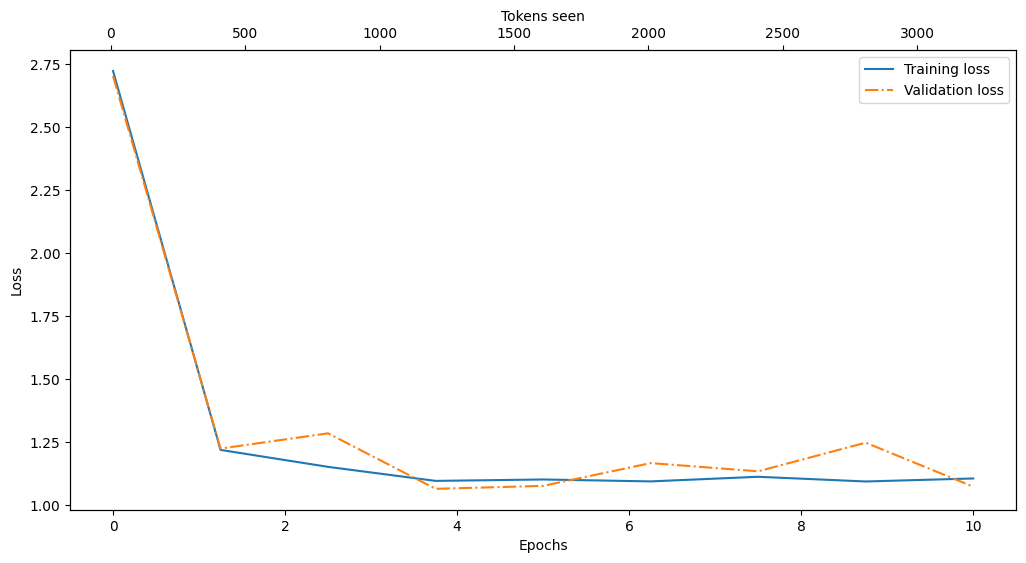

In [17]:
%matplotlib inline

def plot_losses(epochs_seen, tokens_seen, train_looses, validation_looses):
    plt.clf()
    fig, ax1 = plt.subplots()

    fig.set_figwidth(11)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)

    ax1.plot(epochs_seen, train_looses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)

### Plotting the Embedding Changes

In [18]:
trained_embeddings = model.token_embeddings.weight.clone().to("cpu")

In [19]:
def classify(word: str) -> int:
    if word in adjectives:
        return 0
    if word in nouns:
        return 1
    if word in verbs:
        return 2
    return 3

classes = {
    0: "Adjective",
    1: "Noun",
    2: "Verb",
    3: "Keyword",
}

classification = {token: classify(word) for token, word in tokenizer.int_to_str.items()}
classification

{0: 3,
 1: 3,
 2: 1,
 3: 0,
 4: 2,
 5: 2,
 6: 1,
 7: 1,
 8: 1,
 9: 0,
 10: 2,
 11: 0,
 12: 0,
 13: 2}

In [20]:
colors = {
    0: "tab:blue",
    1: "tab:green",
    2: "tab:red",
    3: "tab:purple",
}

<Figure size 640x480 with 0 Axes>

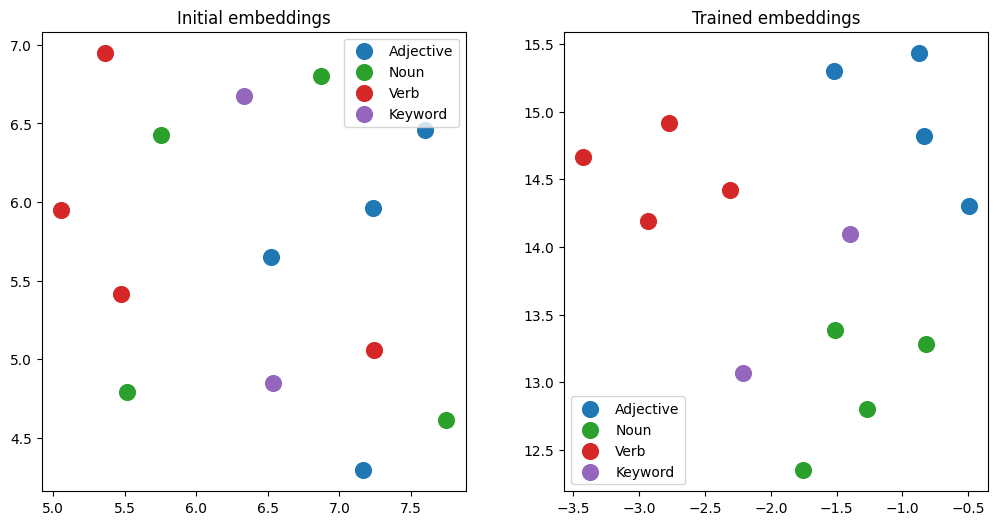

In [21]:
%matplotlib inline

def scat_umap_embeddings(ax: Axes, embeddings: torch.tensor, title: str):
    reducer = umap.UMAP(n_components = 2)
    reduced_embeddings = reducer.fit_transform(embeddings.tolist())
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        selection = np.where(groups == group)
        ax.scatter(
            reduced_embeddings[selection][:, 0],
            reduced_embeddings[selection][:, 1],
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def plot_umap_embedding_changes():
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    fig.set_figwidth(11)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    scat_umap_embeddings(ax1, initial_embeddings, "Initial embeddings")
    scat_umap_embeddings(ax2, trained_embeddings, "Trained embeddings")
    
    plt.show()

plot_umap_embedding_changes()

In [22]:
def categorized_3d_scat(ax: Axes, values: torch.tensor, title: str):
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        index = np.where(groups == group)
        ax.scatter(
            values[index][:, 0].detach().numpy(),
            values[index][:, 1].detach().numpy(),
            values[index][:, 2].detach().numpy(),
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def compare_3d_plots(
    initial_values: torch.tensor,
    final_values: torch.tensor,
    initial_title: str = "Initial",
    final_title: str = "Final"
):
    plt.clf()
    fig = plt.figure(1, 2)
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    categorized_3d_scat(ax1, initial_values, initial_title)
    categorized_3d_scat(ax2, final_values, final_title)
    
    plt.show()

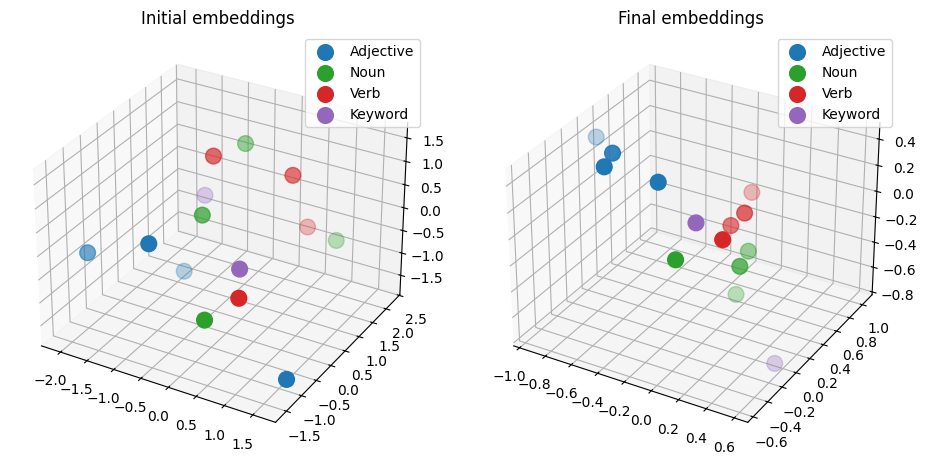

In [23]:
# Apparently only one chart can be rendered as an interactive widget at a time.
# Change this to %matplotlib widget to make this chart interactive.
# When you are done, set it back to %matplotlib inline.
%matplotlib inline

if config.embedding_dimension == 3:
    compare_3d_plots(initial_embeddings, trained_embeddings, "Initial embeddings", "Final embeddings")

### Plotting the Out-Head Changes

In [24]:
trained_out_head = model.out_head.weight.clone().to("cpu")

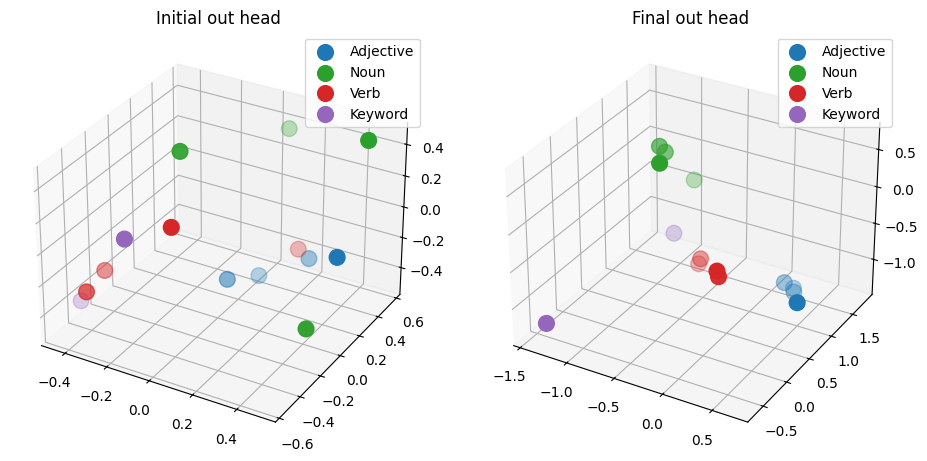

In [25]:
# Apparently only one chart can be rendered as an interactive widget at a time.
# Change this to %matplotlib widget to make this chart interactive.
# When you are done, set it back to %matplotlib inline.
%matplotlib inline

if config.embedding_dimension == 3:
    compare_3d_plots(initial_out_head, trained_out_head, "Initial out head", "Final out head")

## Debugging the Model

### Debugging the Inference

In [26]:
model.enable_debugging()

input_text = random.choice(adjectives) + " " + random.choice(nouns)

idx = tokenizer.text_to_tokens(input_text).to(trainer.device)
logits = model(idx)
next_idx = logits.argmax(dim = -1)
generated_text = tokenizer.tokens_to_text(next_idx)

model.disable_debugging()

In [27]:
def plot_bars(ax: Axes, values: torch.tensor, labels: list, colors: list, title: str, suptitle: str):
    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)

    ax.bar(labels, values.tolist(), color = colors)
    ax.set_title(title)
    fig.suptitle(suptitle)
    ax.set_xticklabels(labels, rotation=75)
    fig.show()

labels = tokenizer.int_to_str.values()
classification_colors = [colors[classification] for classification in classification.values()]

#### Plotting the Out Head

As we enabled `enable_debugging` before running the inference, we can now check the value of the `debug_bag`, where we'll found the output values of each layer.

In [28]:
out_head = model.debug_bag["out_head"].squeeze()

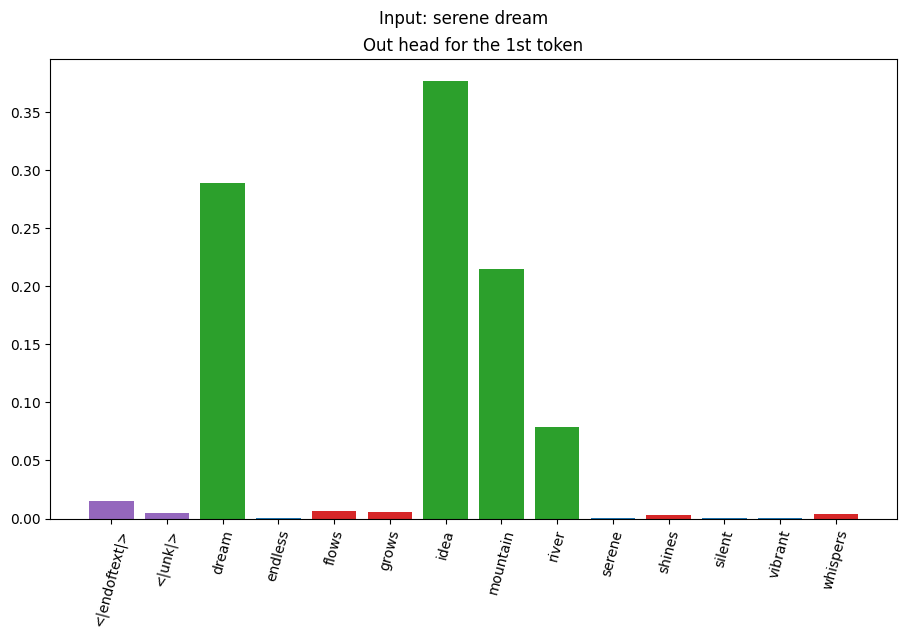

In [29]:
probs = out_head[0].softmax(dim = -1)

fig, ax = plt.subplots()
plot_bars(ax, probs, labels, classification_colors, "Out head for the 1st token", "Input: " + input_text)

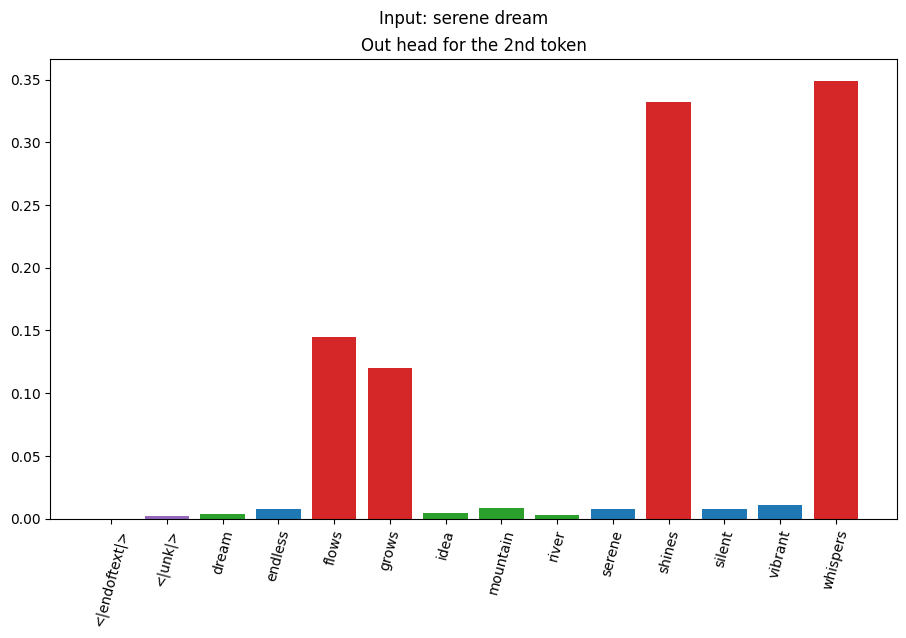

In [30]:
probs = out_head[1].softmax(dim = -1)

fig, ax = plt.subplots()
plot_bars(ax, probs, labels, classification_colors, "Out head for the 2nd token", "Input: " + input_text)

##### Interactively Inspecting the Out Head

In [31]:
def inspect_out_head(x: float, y: float, z: float):
    plt.clf()
    fig = plt.figure(1, 2)
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection=None)
    
    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)

    # Plot what we'll send to the out head
    categorized_3d_scat(ax1, trained_embeddings, 'Interactive input for the out head')

    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')

    ax1.scatter(
        x,
        y,
        z,
        s = 128,
        c = 'tab:orange',
        label = 'Selection'
    )
    ax1.legend()

    # Plot what we receive from the out head
    latent_value = torch.tensor((x, y, z)).to('cuda')
    probs = model.out_head(latent_value).softmax(dim = -1)
    plot_bars(ax2, probs, labels, classification_colors, 'Out head for the interactive input', '')

    plt.show()

In [32]:
# Apparently only one chart can be rendered as an interactive widget at a time.
# Change this to %matplotlib widget to make this chart interactive.
# When you are done, set it back to %matplotlib inline.
%matplotlib inline

widgets.interact(
    inspect_out_head,
    x=(-1, 1, 0.01),
    y=(-1, 1, 0.01),
    z=(-1, 1, 0.01)
)

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), FloatSlider(value…

<function __main__.inspect_out_head(x: float, y: float, z: float)>

#### Plotting the Latent Space Life Cycle

In [33]:
final_normalization = model.debug_bag["final_normalization"].squeeze().clone().to("cpu")
transformer_blocks = model.debug_bag["transformer_blocks"].squeeze().clone().to("cpu")
dropout_embeddings = model.debug_bag["dropout_embeddings"].squeeze().clone().to("cpu")
positional_embeddings = model.debug_bag["positional_embeddings"].squeeze().clone().to("cpu")
token_embeddings = model.debug_bag["token_embeddings"].squeeze().clone().to("cpu")

In [34]:
def scat_3d_embedding(ax: Axes, embedding: torch.tensor, color: str, label: str, marker = 'o', size: int = 64):
    ax.scatter(
        embedding[0].detach().numpy(),
        embedding[1].detach().numpy(),
        embedding[2].detach().numpy(),
        s = size,
        color = color,
        label = label,
        marker = marker,
    )

In [35]:
def scat_token_cycle(ax: Axes, token_index: int, color: str):
    color = 'black'

    if token_index == 0:
        scat_3d_embedding(ax, token_embeddings[token_index], color, 'Token embeddings', 'o', 8)
        scat_3d_embedding(ax, positional_embeddings[token_index], color, 'Positional embeddings', 'o', 16)
        scat_3d_embedding(ax, dropout_embeddings[token_index], color, 'Dropout embeddings', 'o', 32)
        scat_3d_embedding(ax, transformer_blocks[token_index], color, 'Transformer blocks', 'o', 64)
        scat_3d_embedding(ax, final_normalization[token_index], color, 'Final normalization', 'o', 128)
    else:
        scat_3d_embedding(ax, token_embeddings[token_index], color, '', 'o', 8)
        scat_3d_embedding(ax, positional_embeddings[token_index], color, '', 'o', 16)
        scat_3d_embedding(ax, dropout_embeddings[token_index], color, '', 'o', 32)
        scat_3d_embedding(ax, transformer_blocks[token_index], color, '', 'o', 64)
        scat_3d_embedding(ax, final_normalization[token_index], color, '', 'o', 128)

def plot_lines(ax: Axes, token_index: int, color: str, label: str):
    token_history = torch.stack([
        token_embeddings[token_index],
        positional_embeddings[token_index],
        dropout_embeddings[token_index],
        transformer_blocks[token_index],
        final_normalization[token_index],
    ])

    x = token_history[: ,0].detach().numpy(),
    y = token_history[: ,1].detach().numpy(),
    z = token_history[: ,2].detach().numpy(),

    ax.plot(x, y, z, color = color, label = label)

<Figure size 640x480 with 0 Axes>

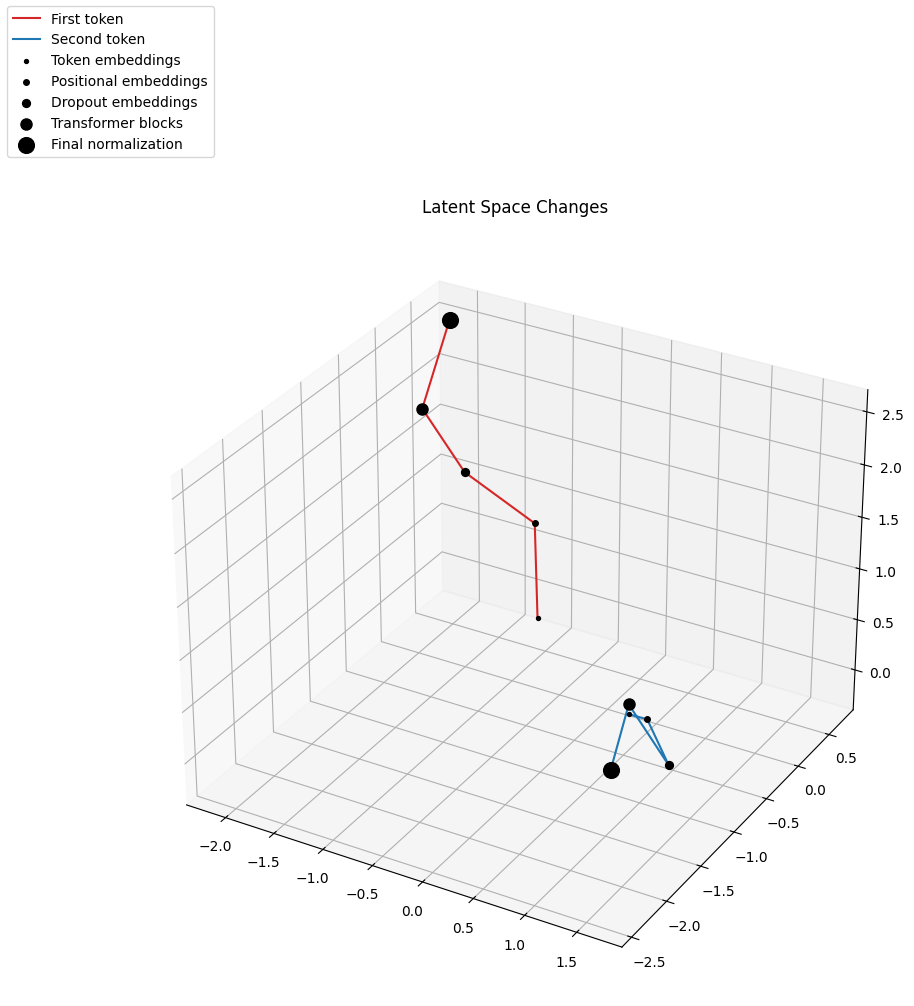

In [36]:
# Apparently only one chart can be rendered as an interactive widget at a time.
# Change this to %matplotlib widget to make this chart interactive.
# When you are done, set it back to %matplotlib inline.
%matplotlib inline

if config.embedding_dimension == 3:
    plt.clf()

    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(12)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)

    ax = fig.add_subplot(projection='3d')

    plot_lines(ax, 0, "tab:red", "First token")
    plot_lines(ax, 1, "tab:blue", "Second token")

    scat_token_cycle(ax, 0, "tab:red")
    scat_token_cycle(ax, 1, "tab:blue")

    fig.legend(loc="upper left")
    plt.title("Latent Space Changes")
    plt.show()